# Statistical Analysis & Parameter Tuning for CVRP Solver

This notebook performs comprehensive statistical analysis of the CVRP solver by:
1. Testing different parameter configurations
2. Analyzing the impact of each parameter
3. Visualizing results with plots
4. Exporting data to CSV for further analysis

## Parameters to analyze:
- Initial temperature (SA)
- Cooling rate (alpha)
- Tabu tenure
- Iterations per temperature
- Initial solution randomness

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import vrplib
import yaml
import random
import math
import time
import os
from collections import deque
from copy import deepcopy
from typing import List, Dict, Tuple, Optional
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load base configuration
with open('config.yaml', 'r') as f:
    base_config = yaml.safe_load(f)

print("Base configuration loaded!")

Base configuration loaded!


## Copy Solver Functions from Main Notebook

We'll import the necessary functions from the main solver notebook.

In [3]:
# Load the solver code from the main notebook
# Note: In practice, this should be a proper import from a .py module
# For simplicity, we'll use %run magic command

# Since we can't easily import from .ipynb, we'll redefine key classes here
# Alternatively, convert the solver notebook to a .py file first

class CVRPSolution:
    """Represents a CVRP solution with routes and cost."""
    
    def __init__(self, routes: List[List[int]], distance_matrix: np.ndarray):
        self.routes = routes
        self.distance_matrix = distance_matrix
        self.cost = self.calculate_cost()
    
    def calculate_cost(self) -> float:
        total_cost = 0
        for route in self.routes:
            if len(route) == 0:
                continue
            total_cost += self.distance_matrix[0, route[0]]
            for i in range(len(route) - 1):
                total_cost += self.distance_matrix[route[i], route[i+1]]
            total_cost += self.distance_matrix[route[-1], 0]
        return total_cost
    
    def update_cost(self):
        self.cost = self.calculate_cost()
    
    def is_feasible(self, demands: np.ndarray, capacity: int) -> bool:
        for route in self.routes:
            route_demand = sum(demands[customer] for customer in route)
            if route_demand > capacity:
                return False
        return True
    
    def copy(self):
        return CVRPSolution([route.copy() for route in self.routes], self.distance_matrix)

print("CVRPSolution class defined!")

CVRPSolution class defined!


In [4]:
# Helper functions (copied from main notebook)

def calculate_distance_matrix(instance: Dict) -> np.ndarray:
    if 'edge_weight' in instance:
        return instance['edge_weight']
    elif 'node_coord' in instance:
        coords = np.array(instance['node_coord'])
        n = len(coords)
        dist_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if i != j:
                    dist = np.sqrt(np.sum((coords[i] - coords[j])**2))
                    dist_matrix[i, j] = dist
        return dist_matrix
    else:
        raise ValueError("Instance must have either 'edge_weight' or 'node_coord'")

def nearest_neighbor_solution(instance: Dict, distance_matrix: np.ndarray, config: Dict) -> CVRPSolution:
    n_customers = instance['dimension'] - 1
    capacity = instance['capacity']
    demands = np.array(instance['demand'])
    
    unvisited = set(range(1, n_customers + 1))
    routes = []
    
    while unvisited:
        route = []
        current_load = 0
        current_node = 0
        
        while True:
            best_customer = None
            best_distance = float('inf')
            
            for customer in unvisited:
                if current_load + demands[customer] <= capacity:
                    dist = distance_matrix[current_node, customer]
                    randomness = config['initial_solution']['randomness']
                    dist *= (1 + randomness * random.random())
                    
                    if dist < best_distance:
                        best_distance = dist
                        best_customer = customer
            
            if best_customer is None:
                break
            
            route.append(best_customer)
            current_load += demands[best_customer]
            current_node = best_customer
            unvisited.remove(best_customer)
        
        if route:
            routes.append(route)
    
    return CVRPSolution(routes, distance_matrix)

print("Helper functions defined!")

Helper functions defined!


In [5]:
# Neighborhood operators (simplified versions)

def swap_operator(solution: CVRPSolution, demands: np.ndarray, capacity: int) -> Optional[CVRPSolution]:
    if len(solution.routes) < 2:
        return None
    
    best_solution = None
    best_cost = solution.cost
    
    for i in range(len(solution.routes)):
        for j in range(i + 1, len(solution.routes)):
            route_i = solution.routes[i]
            route_j = solution.routes[j]
            
            if len(route_i) == 0 or len(route_j) == 0:
                continue
            
            for pos_i in range(len(route_i)):
                for pos_j in range(len(route_j)):
                    new_solution = solution.copy()
                    new_solution.routes[i][pos_i], new_solution.routes[j][pos_j] = \
                        new_solution.routes[j][pos_j], new_solution.routes[i][pos_i]
                    
                    if new_solution.is_feasible(demands, capacity):
                        new_solution.update_cost()
                        if new_solution.cost < best_cost:
                            best_cost = new_solution.cost
                            best_solution = new_solution
    
    return best_solution

def relocate_operator(solution: CVRPSolution, demands: np.ndarray, capacity: int) -> Optional[CVRPSolution]:
    best_solution = None
    best_cost = solution.cost
    
    for i in range(len(solution.routes)):
        route_i = solution.routes[i]
        if len(route_i) == 0:
            continue
            
        for pos_i in range(len(route_i)):
            for j in range(len(solution.routes)):
                if i == j:
                    continue
                
                for pos_j in range(len(solution.routes[j]) + 1):
                    new_solution = solution.copy()
                    removed = new_solution.routes[i].pop(pos_i)
                    new_solution.routes[j].insert(pos_j, removed)
                    
                    if new_solution.is_feasible(demands, capacity):
                        new_solution.update_cost()
                        if new_solution.cost < best_cost:
                            best_cost = new_solution.cost
                            best_solution = new_solution
    
    return best_solution

def two_opt_operator(solution: CVRPSolution, demands: np.ndarray, capacity: int) -> Optional[CVRPSolution]:
    best_solution = None
    best_cost = solution.cost
    
    for route_idx in range(len(solution.routes)):
        route = solution.routes[route_idx]
        if len(route) < 2:
            continue
        
        for i in range(len(route) - 1):
            for j in range(i + 1, len(route)):
                new_solution = solution.copy()
                new_solution.routes[route_idx][i:j+1] = reversed(new_solution.routes[route_idx][i:j+1])
                
                new_solution.update_cost()
                if new_solution.cost < best_cost:
                    best_cost = new_solution.cost
                    best_solution = new_solution
    
    return best_solution

print("Neighborhood operators defined!")

Neighborhood operators defined!


In [6]:
# VND and SA functions (simplified)

def vnd(solution: CVRPSolution, demands: np.ndarray, capacity: int, config: Dict) -> CVRPSolution:
    neighborhoods = {'swap': swap_operator, 'relocate': relocate_operator, 'two_opt': two_opt_operator}
    neighborhood_order = config['vnd']['neighborhoods'][:3]  # Use first 3 for speed
    max_no_improve = config['vnd']['max_iterations_without_improvement']
    
    current_solution = solution
    k = 0
    no_improve_count = 0
    
    while k < len(neighborhood_order) and no_improve_count < max_no_improve:
        neighborhood_name = neighborhood_order[k]
        operator = neighborhoods[neighborhood_name]
        new_solution = operator(current_solution, demands, capacity)
        
        if new_solution is not None and new_solution.cost < current_solution.cost:
            current_solution = new_solution
            k = 0
            no_improve_count = 0
        else:
            k += 1
            no_improve_count += 1
    
    return current_solution

class TabuList:
    def __init__(self, tenure: int):
        self.tenure = tenure
        self.tabu_dict = {}
        self.current_iteration = 0
    
    def add(self, move: Tuple, tenure_variation: int = 0):
        actual_tenure = self.tenure + random.randint(-tenure_variation, tenure_variation)
        self.tabu_dict[move] = self.current_iteration + actual_tenure
    
    def is_tabu(self, move: Tuple) -> bool:
        if move not in self.tabu_dict:
            return False
        return self.tabu_dict[move] > self.current_iteration
    
    def increment_iteration(self):
        self.current_iteration += 1
        expired = [move for move, expiration in self.tabu_dict.items() 
                   if expiration <= self.current_iteration]
        for move in expired:
            del self.tabu_dict[move]

def acceptance_probability(current_cost: float, new_cost: float, temperature: float) -> float:
    if new_cost < current_cost:
        return 1.0
    return math.exp((current_cost - new_cost) / temperature)

print("VND and helper classes defined!")

VND and helper classes defined!


In [7]:
# Simplified SA solver for parameter testing

def solve_with_config(instance_path: str, config: Dict, time_limit: float = 60) -> Dict:
    """Solve instance with specific configuration."""
    
    # Set random seed
    random.seed(config['general']['random_seed'])
    np.random.seed(config['general']['random_seed'])
    
    # Read instance
    try:
        instance = vrplib.read_instance(instance_path)
    except:
        instance = vrplib.read_instance(instance_path, instance_format='solomon')
    
    distance_matrix = calculate_distance_matrix(instance)
    demands = np.array(instance['demand'])
    capacity = instance['capacity']
    
    # Create initial solution
    initial_solution = nearest_neighbor_solution(instance, distance_matrix, config)
    
    # Apply VND
    improved_solution = vnd(initial_solution, demands, capacity, config)
    
    # Apply SA with Tabu (simplified version)
    temp = config['simulated_annealing']['initial_temperature']
    final_temp = config['simulated_annealing']['final_temperature']
    alpha = config['simulated_annealing']['alpha']
    iterations_per_temp = config['simulated_annealing']['iterations_per_temperature']
    
    tabu_tenure = config['tabu_search']['tabu_tenure']
    tabu_list = TabuList(tabu_tenure)
    
    current_solution = improved_solution
    best_solution = current_solution.copy()
    
    operators = [swap_operator, relocate_operator, two_opt_operator]
    
    start_time = time.time()
    iterations = 0
    
    while temp > final_temp and (time.time() - start_time) < time_limit:
        for _ in range(iterations_per_temp):
            operator = random.choice(operators)
            new_solution = operator(current_solution, demands, capacity)
            
            if new_solution is None:
                continue
            
            if random.random() < acceptance_probability(current_solution.cost, new_solution.cost, temp):
                current_solution = new_solution
                
                if current_solution.cost < best_solution.cost:
                    best_solution = current_solution.copy()
            
            iterations += 1
        
        temp *= alpha
    
    elapsed_time = time.time() - start_time
    
    # Get optimal cost
    optimal_cost = None
    sol_path = instance_path.replace('.vrp', '.sol').replace('.txt', '.sol')
    if os.path.exists(sol_path):
        try:
            optimal_solution = vrplib.read_solution(sol_path)
            optimal_cost = optimal_solution['cost']
        except:
            pass
    
    gap = None
    if optimal_cost:
        gap = ((best_solution.cost - optimal_cost) / optimal_cost) * 100
    
    return {
        'cost': best_solution.cost,
        'optimal_cost': optimal_cost,
        'gap': gap,
        'time': elapsed_time,
        'iterations': iterations
    }

print("Simplified solver function defined!")

Simplified solver function defined!


## Select Test Instances

We'll use a subset of smaller instances for faster experimentation.

In [8]:
# Select test instances
test_instances = [
    'data/E-n13-k4.vrp',
    'data/A-n32-k5.vrp',
    'data/B-n31-k5.vrp',
    'data/P-n16-k8.vrp'
]

# Filter to only existing files
test_instances = [inst for inst in test_instances if os.path.exists(inst)]

print(f"Selected {len(test_instances)} test instances:")
for inst in test_instances:
    print(f"  - {inst}")

Selected 4 test instances:
  - data/E-n13-k4.vrp
  - data/A-n32-k5.vrp
  - data/B-n31-k5.vrp
  - data/P-n16-k8.vrp


## Experiment 1: Impact of Initial Temperature

In [9]:
print("Experiment 1: Testing different initial temperatures...\n")

# Parameter values to test
temperature_values = [100, 500, 1000, 2000, 5000]

results_temp = []

for instance_path in test_instances:
    instance_name = os.path.basename(instance_path)
    print(f"Testing {instance_name}...")
    
    for temp in temperature_values:
        # Create modified config
        test_config = deepcopy(base_config)
        test_config['simulated_annealing']['initial_temperature'] = temp
        
        # Run solver
        result = solve_with_config(instance_path, test_config, time_limit=30)
        
        results_temp.append({
            'instance': instance_name,
            'initial_temperature': temp,
            'cost': result['cost'],
            'optimal_cost': result['optimal_cost'],
            'gap': result['gap'],
            'time': result['time']
        })
        
        print(f"  Temp={temp}: Cost={result['cost']:.2f}, Gap={result['gap']:.2f}% (if known)")
    print()

df_temp = pd.DataFrame(results_temp)
print("\nExperiment 1 completed!")

Experiment 1: Testing different initial temperatures...

Testing E-n13-k4.vrp...
  Temp=100: Cost=290.00, Gap=17.41% (if known)
  Temp=500: Cost=290.00, Gap=17.41% (if known)
  Temp=1000: Cost=290.00, Gap=17.41% (if known)
  Temp=2000: Cost=290.00, Gap=17.41% (if known)
  Temp=5000: Cost=290.00, Gap=17.41% (if known)

Testing A-n32-k5.vrp...
  Temp=100: Cost=865.65, Gap=10.41% (if known)
  Temp=500: Cost=865.65, Gap=10.41% (if known)
  Temp=1000: Cost=865.65, Gap=10.41% (if known)
  Temp=2000: Cost=865.65, Gap=10.41% (if known)
  Temp=5000: Cost=865.65, Gap=10.41% (if known)

Testing B-n31-k5.vrp...
  Temp=100: Cost=676.09, Gap=0.61% (if known)
  Temp=500: Cost=676.09, Gap=0.61% (if known)
  Temp=1000: Cost=676.09, Gap=0.61% (if known)
  Temp=2000: Cost=676.09, Gap=0.61% (if known)
  Temp=5000: Cost=676.09, Gap=0.61% (if known)

Testing P-n16-k8.vrp...
  Temp=100: Cost=451.95, Gap=0.43% (if known)
  Temp=500: Cost=451.95, Gap=0.43% (if known)
  Temp=1000: Cost=451.95, Gap=0.43% (if kno

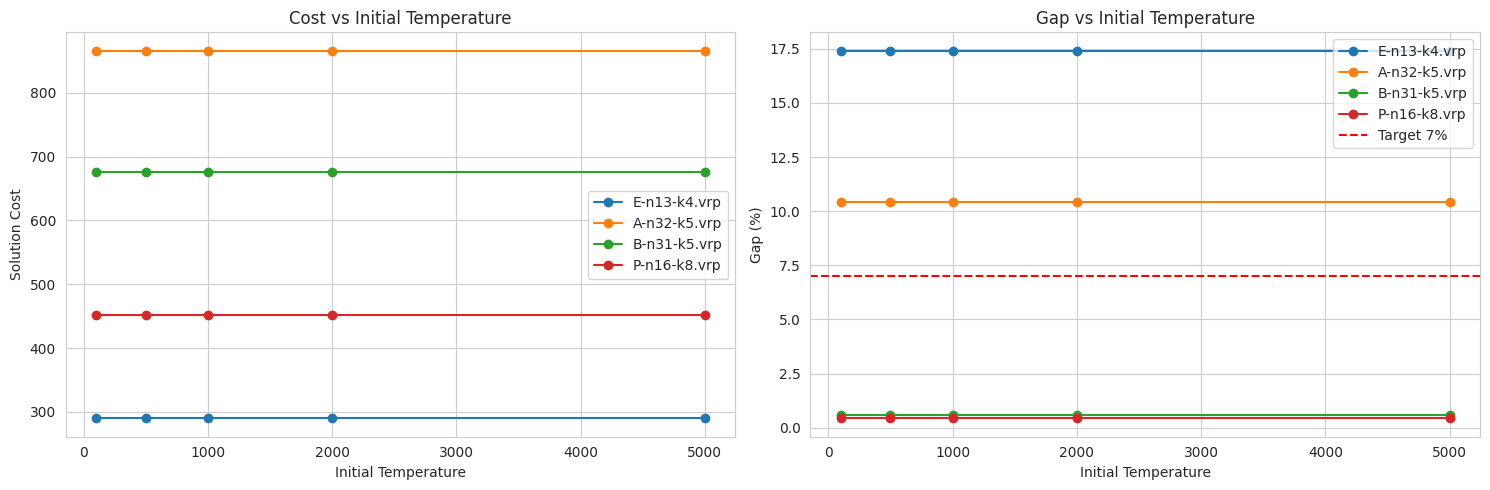

Plot saved to: analysis_results/plots/experiment1_temperature.png


In [10]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Cost vs Temperature
for instance in df_temp['instance'].unique():
    data = df_temp[df_temp['instance'] == instance]
    axes[0].plot(data['initial_temperature'], data['cost'], marker='o', label=instance)

axes[0].set_xlabel('Initial Temperature')
axes[0].set_ylabel('Solution Cost')
axes[0].set_title('Cost vs Initial Temperature')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Gap vs Temperature (only for instances with known optimal)
df_temp_with_gap = df_temp[df_temp['gap'].notna()]
if not df_temp_with_gap.empty:
    for instance in df_temp_with_gap['instance'].unique():
        data = df_temp_with_gap[df_temp_with_gap['instance'] == instance]
        axes[1].plot(data['initial_temperature'], data['gap'], marker='o', label=instance)
    
    axes[1].axhline(y=7, color='r', linestyle='--', label='Target 7%')
    axes[1].set_xlabel('Initial Temperature')
    axes[1].set_ylabel('Gap (%)')
    axes[1].set_title('Gap vs Initial Temperature')
    axes[1].legend()
    axes[1].grid(True)

plt.tight_layout()
plt.savefig('analysis_results/plots/experiment1_temperature.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to: analysis_results/plots/experiment1_temperature.png")

In [11]:
# Save results to CSV
df_temp.to_csv('analysis_results/csv/experiment1_temperature.csv', index=False)
print("Results saved to: analysis_results/csv/experiment1_temperature.csv")

Results saved to: analysis_results/csv/experiment1_temperature.csv


## Experiment 2: Impact of Cooling Rate (Alpha)

In [12]:
print("Experiment 2: Testing different cooling rates...\n")

# Parameter values to test
alpha_values = [0.85, 0.90, 0.95, 0.97, 0.99]

results_alpha = []

for instance_path in test_instances:
    instance_name = os.path.basename(instance_path)
    print(f"Testing {instance_name}...")
    
    for alpha in alpha_values:
        test_config = deepcopy(base_config)
        test_config['simulated_annealing']['alpha'] = alpha
        
        result = solve_with_config(instance_path, test_config, time_limit=30)
        
        results_alpha.append({
            'instance': instance_name,
            'alpha': alpha,
            'cost': result['cost'],
            'optimal_cost': result['optimal_cost'],
            'gap': result['gap'],
            'time': result['time']
        })
        
        print(f"  Alpha={alpha}: Cost={result['cost']:.2f}, Gap={result['gap']:.2f}% (if known)")
    print()

df_alpha = pd.DataFrame(results_alpha)
print("\nExperiment 2 completed!")

Experiment 2: Testing different cooling rates...

Testing E-n13-k4.vrp...
  Alpha=0.85: Cost=290.00, Gap=17.41% (if known)
  Alpha=0.9: Cost=290.00, Gap=17.41% (if known)
  Alpha=0.95: Cost=290.00, Gap=17.41% (if known)
  Alpha=0.97: Cost=290.00, Gap=17.41% (if known)
  Alpha=0.99: Cost=290.00, Gap=17.41% (if known)

Testing A-n32-k5.vrp...
  Alpha=0.85: Cost=865.65, Gap=10.41% (if known)
  Alpha=0.9: Cost=865.65, Gap=10.41% (if known)
  Alpha=0.95: Cost=865.65, Gap=10.41% (if known)
  Alpha=0.97: Cost=865.65, Gap=10.41% (if known)
  Alpha=0.99: Cost=865.65, Gap=10.41% (if known)

Testing B-n31-k5.vrp...
  Alpha=0.85: Cost=676.09, Gap=0.61% (if known)
  Alpha=0.9: Cost=676.09, Gap=0.61% (if known)
  Alpha=0.95: Cost=676.09, Gap=0.61% (if known)
  Alpha=0.97: Cost=676.09, Gap=0.61% (if known)
  Alpha=0.99: Cost=676.09, Gap=0.61% (if known)

Testing P-n16-k8.vrp...
  Alpha=0.85: Cost=451.95, Gap=0.43% (if known)
  Alpha=0.9: Cost=451.95, Gap=0.43% (if known)
  Alpha=0.95: Cost=451.95, Ga

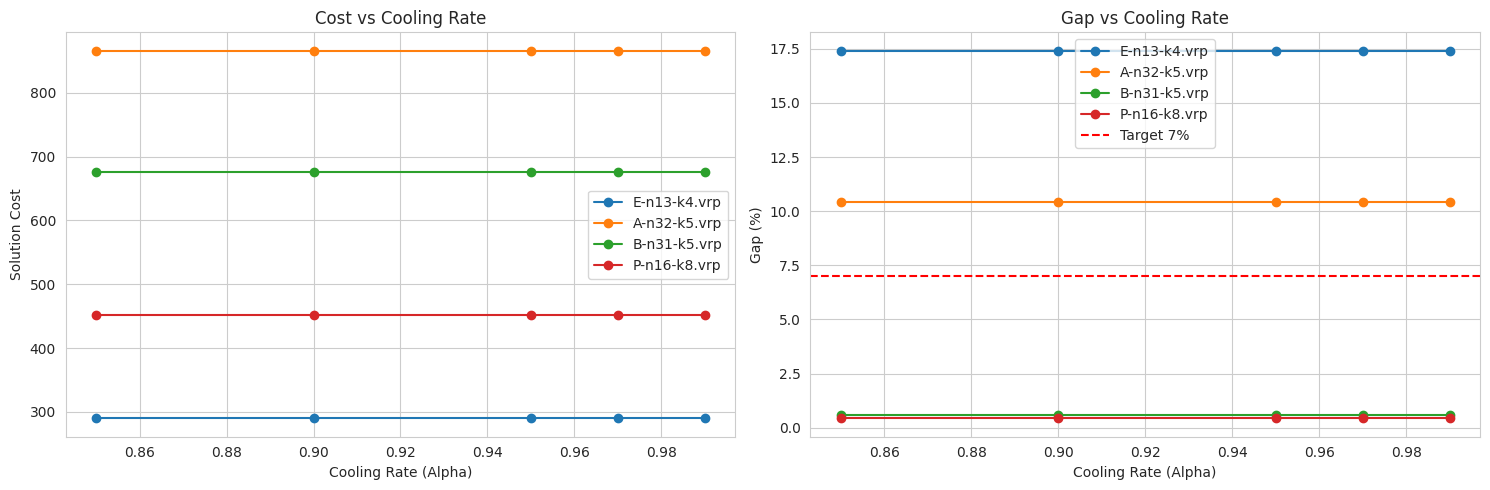

Plot saved to: analysis_results/plots/experiment2_alpha.png


In [13]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Cost vs Alpha
for instance in df_alpha['instance'].unique():
    data = df_alpha[df_alpha['instance'] == instance]
    axes[0].plot(data['alpha'], data['cost'], marker='o', label=instance)

axes[0].set_xlabel('Cooling Rate (Alpha)')
axes[0].set_ylabel('Solution Cost')
axes[0].set_title('Cost vs Cooling Rate')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Gap vs Alpha
df_alpha_with_gap = df_alpha[df_alpha['gap'].notna()]
if not df_alpha_with_gap.empty:
    for instance in df_alpha_with_gap['instance'].unique():
        data = df_alpha_with_gap[df_alpha_with_gap['instance'] == instance]
        axes[1].plot(data['alpha'], data['gap'], marker='o', label=instance)
    
    axes[1].axhline(y=7, color='r', linestyle='--', label='Target 7%')
    axes[1].set_xlabel('Cooling Rate (Alpha)')
    axes[1].set_ylabel('Gap (%)')
    axes[1].set_title('Gap vs Cooling Rate')
    axes[1].legend()
    axes[1].grid(True)

plt.tight_layout()
plt.savefig('analysis_results/plots/experiment2_alpha.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to: analysis_results/plots/experiment2_alpha.png")

In [14]:
# Save results to CSV
df_alpha.to_csv('analysis_results/csv/experiment2_alpha.csv', index=False)
print("Results saved to: analysis_results/csv/experiment2_alpha.csv")

Results saved to: analysis_results/csv/experiment2_alpha.csv


## Experiment 3: Impact of Tabu Tenure

In [15]:
print("Experiment 3: Testing different tabu tenures...\n")

# Parameter values to test
tenure_values = [5, 10, 20, 30, 50]

results_tenure = []

for instance_path in test_instances:
    instance_name = os.path.basename(instance_path)
    print(f"Testing {instance_name}...")
    
    for tenure in tenure_values:
        test_config = deepcopy(base_config)
        test_config['tabu_search']['tabu_tenure'] = tenure
        
        result = solve_with_config(instance_path, test_config, time_limit=30)
        
        results_tenure.append({
            'instance': instance_name,
            'tabu_tenure': tenure,
            'cost': result['cost'],
            'optimal_cost': result['optimal_cost'],
            'gap': result['gap'],
            'time': result['time']
        })
        
        print(f"  Tenure={tenure}: Cost={result['cost']:.2f}, Gap={result['gap']:.2f}% (if known)")
    print()

df_tenure = pd.DataFrame(results_tenure)
print("\nExperiment 3 completed!")

Experiment 3: Testing different tabu tenures...

Testing E-n13-k4.vrp...
  Tenure=5: Cost=290.00, Gap=17.41% (if known)
  Tenure=10: Cost=290.00, Gap=17.41% (if known)
  Tenure=20: Cost=290.00, Gap=17.41% (if known)
  Tenure=30: Cost=290.00, Gap=17.41% (if known)
  Tenure=50: Cost=290.00, Gap=17.41% (if known)

Testing A-n32-k5.vrp...
  Tenure=5: Cost=865.65, Gap=10.41% (if known)
  Tenure=10: Cost=865.65, Gap=10.41% (if known)
  Tenure=20: Cost=865.65, Gap=10.41% (if known)
  Tenure=30: Cost=865.65, Gap=10.41% (if known)
  Tenure=50: Cost=865.65, Gap=10.41% (if known)

Testing B-n31-k5.vrp...
  Tenure=5: Cost=676.09, Gap=0.61% (if known)
  Tenure=10: Cost=676.09, Gap=0.61% (if known)
  Tenure=20: Cost=676.09, Gap=0.61% (if known)
  Tenure=30: Cost=676.09, Gap=0.61% (if known)
  Tenure=50: Cost=676.09, Gap=0.61% (if known)

Testing P-n16-k8.vrp...
  Tenure=5: Cost=451.95, Gap=0.43% (if known)
  Tenure=10: Cost=451.95, Gap=0.43% (if known)
  Tenure=20: Cost=451.95, Gap=0.43% (if known)


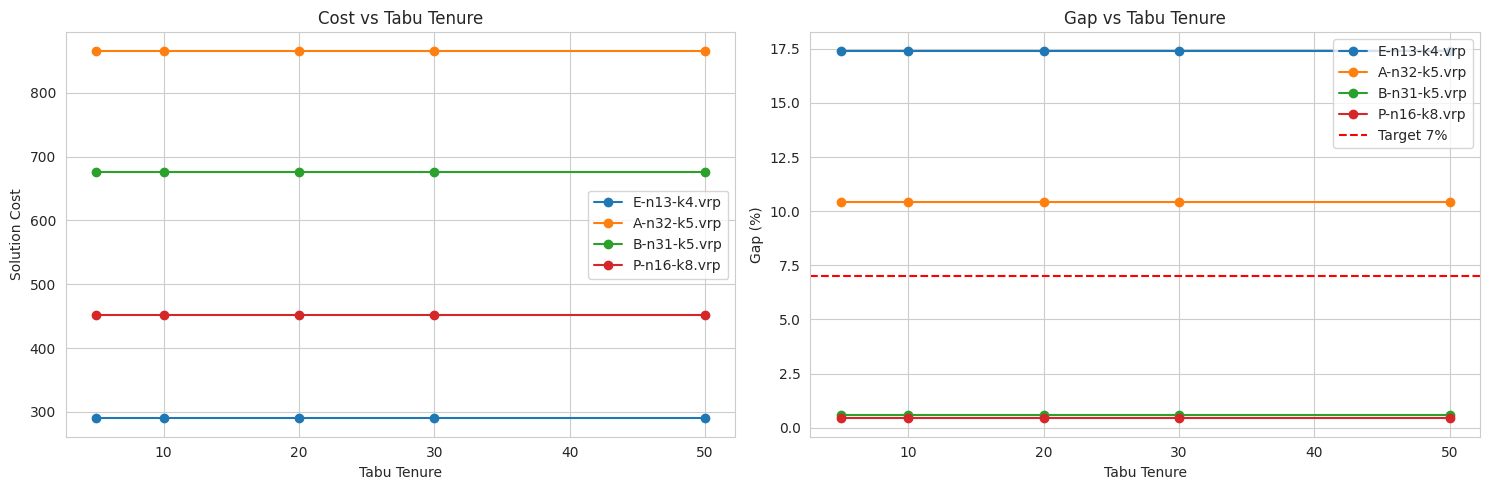

Plot saved to: analysis_results/plots/experiment3_tenure.png


In [16]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Cost vs Tenure
for instance in df_tenure['instance'].unique():
    data = df_tenure[df_tenure['instance'] == instance]
    axes[0].plot(data['tabu_tenure'], data['cost'], marker='o', label=instance)

axes[0].set_xlabel('Tabu Tenure')
axes[0].set_ylabel('Solution Cost')
axes[0].set_title('Cost vs Tabu Tenure')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Gap vs Tenure
df_tenure_with_gap = df_tenure[df_tenure['gap'].notna()]
if not df_tenure_with_gap.empty:
    for instance in df_tenure_with_gap['instance'].unique():
        data = df_tenure_with_gap[df_tenure_with_gap['instance'] == instance]
        axes[1].plot(data['tabu_tenure'], data['gap'], marker='o', label=instance)
    
    axes[1].axhline(y=7, color='r', linestyle='--', label='Target 7%')
    axes[1].set_xlabel('Tabu Tenure')
    axes[1].set_ylabel('Gap (%)')
    axes[1].set_title('Gap vs Tabu Tenure')
    axes[1].legend()
    axes[1].grid(True)

plt.tight_layout()
plt.savefig('analysis_results/plots/experiment3_tenure.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to: analysis_results/plots/experiment3_tenure.png")

In [17]:
# Save results to CSV
df_tenure.to_csv('analysis_results/csv/experiment3_tenure.csv', index=False)
print("Results saved to: analysis_results/csv/experiment3_tenure.csv")

Results saved to: analysis_results/csv/experiment3_tenure.csv


## Experiment 4: Impact of Iterations per Temperature

In [18]:
print("Experiment 4: Testing different iterations per temperature...\n")

# Parameter values to test
iterations_values = [50, 100, 200, 300]

results_iterations = []

for instance_path in test_instances:
    instance_name = os.path.basename(instance_path)
    print(f"Testing {instance_name}...")
    
    for iters in iterations_values:
        test_config = deepcopy(base_config)
        test_config['simulated_annealing']['iterations_per_temperature'] = iters
        
        result = solve_with_config(instance_path, test_config, time_limit=30)
        
        results_iterations.append({
            'instance': instance_name,
            'iterations_per_temp': iters,
            'cost': result['cost'],
            'optimal_cost': result['optimal_cost'],
            'gap': result['gap'],
            'time': result['time']
        })
        
        print(f"  Iterations={iters}: Cost={result['cost']:.2f}, Gap={result['gap']:.2f}% (if known)")
    print()

df_iterations = pd.DataFrame(results_iterations)
print("\nExperiment 4 completed!")

Experiment 4: Testing different iterations per temperature...

Testing E-n13-k4.vrp...
  Iterations=50: Cost=290.00, Gap=17.41% (if known)
  Iterations=100: Cost=290.00, Gap=17.41% (if known)
  Iterations=200: Cost=290.00, Gap=17.41% (if known)
  Iterations=300: Cost=290.00, Gap=17.41% (if known)

Testing A-n32-k5.vrp...
  Iterations=50: Cost=865.65, Gap=10.41% (if known)
  Iterations=100: Cost=865.65, Gap=10.41% (if known)
  Iterations=200: Cost=865.65, Gap=10.41% (if known)
  Iterations=300: Cost=865.65, Gap=10.41% (if known)

Testing B-n31-k5.vrp...
  Iterations=50: Cost=676.09, Gap=0.61% (if known)
  Iterations=100: Cost=676.09, Gap=0.61% (if known)
  Iterations=200: Cost=676.09, Gap=0.61% (if known)
  Iterations=300: Cost=676.09, Gap=0.61% (if known)

Testing P-n16-k8.vrp...
  Iterations=50: Cost=451.95, Gap=0.43% (if known)
  Iterations=100: Cost=451.95, Gap=0.43% (if known)
  Iterations=200: Cost=451.95, Gap=0.43% (if known)
  Iterations=300: Cost=451.95, Gap=0.43% (if known)




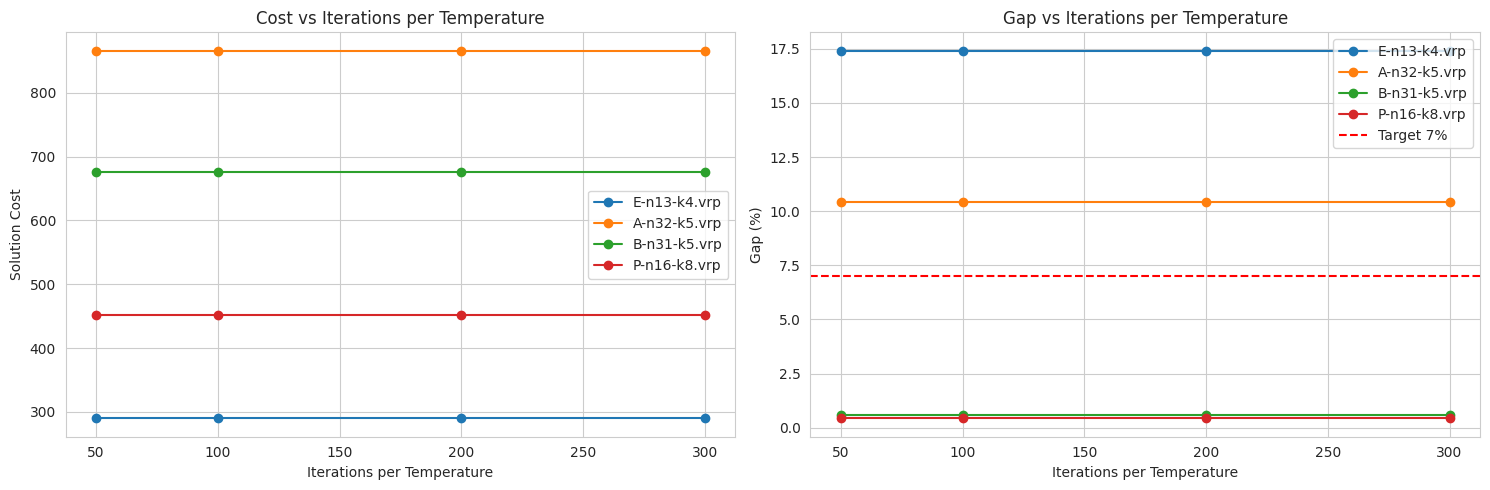

Plot saved to: analysis_results/plots/experiment4_iterations.png


In [19]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Cost vs Iterations
for instance in df_iterations['instance'].unique():
    data = df_iterations[df_iterations['instance'] == instance]
    axes[0].plot(data['iterations_per_temp'], data['cost'], marker='o', label=instance)

axes[0].set_xlabel('Iterations per Temperature')
axes[0].set_ylabel('Solution Cost')
axes[0].set_title('Cost vs Iterations per Temperature')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Gap vs Iterations
df_iterations_with_gap = df_iterations[df_iterations['gap'].notna()]
if not df_iterations_with_gap.empty:
    for instance in df_iterations_with_gap['instance'].unique():
        data = df_iterations_with_gap[df_iterations_with_gap['instance'] == instance]
        axes[1].plot(data['iterations_per_temp'], data['gap'], marker='o', label=instance)
    
    axes[1].axhline(y=7, color='r', linestyle='--', label='Target 7%')
    axes[1].set_xlabel('Iterations per Temperature')
    axes[1].set_ylabel('Gap (%)')
    axes[1].set_title('Gap vs Iterations per Temperature')
    axes[1].legend()
    axes[1].grid(True)

plt.tight_layout()
plt.savefig('analysis_results/plots/experiment4_iterations.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to: analysis_results/plots/experiment4_iterations.png")

In [20]:
# Save results to CSV
df_iterations.to_csv('analysis_results/csv/experiment4_iterations.csv', index=False)
print("Results saved to: analysis_results/csv/experiment4_iterations.csv")

Results saved to: analysis_results/csv/experiment4_iterations.csv


## Comprehensive Analysis: Heatmaps

Creating parameter interaction heatmap...

Temp=500, Alpha=0.9: Gap=17.41% (if known)
Temp=500, Alpha=0.95: Gap=17.41% (if known)
Temp=500, Alpha=0.97: Gap=17.41% (if known)
Temp=1000, Alpha=0.9: Gap=17.41% (if known)
Temp=1000, Alpha=0.95: Gap=17.41% (if known)
Temp=1000, Alpha=0.97: Gap=17.41% (if known)
Temp=2000, Alpha=0.9: Gap=17.41% (if known)
Temp=2000, Alpha=0.95: Gap=17.41% (if known)
Temp=2000, Alpha=0.97: Gap=17.41% (if known)


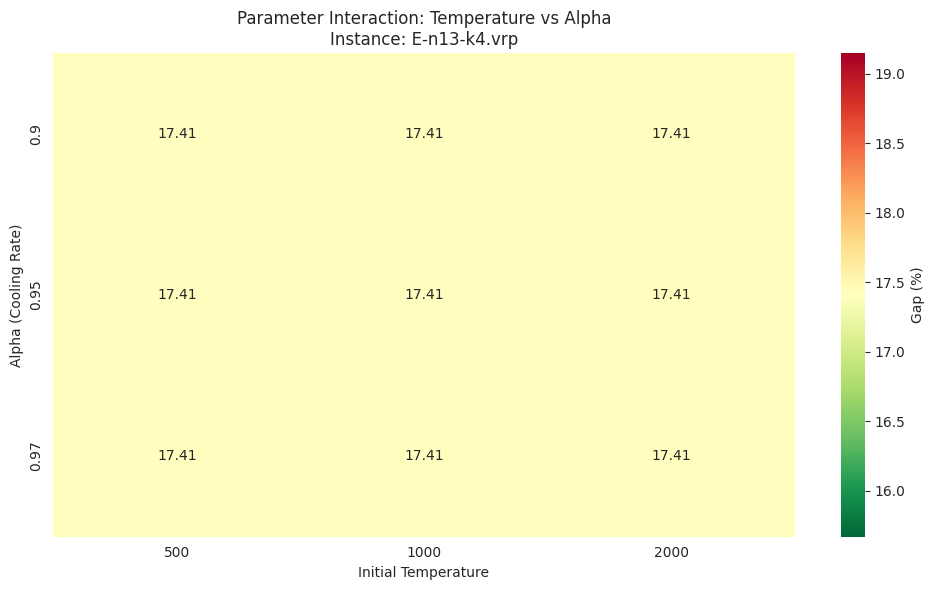


Heatmap saved to: analysis_results/plots/heatmap_temp_alpha.png


In [21]:
# Create heatmap for parameter interactions (Temperature vs Alpha)
print("Creating parameter interaction heatmap...\n")

# Use a single small instance for speed
test_instance = test_instances[0]
instance_name = os.path.basename(test_instance)

temp_range = [500, 1000, 2000]
alpha_range = [0.90, 0.95, 0.97]

heatmap_data = []

for temp in temp_range:
    for alpha in alpha_range:
        test_config = deepcopy(base_config)
        test_config['simulated_annealing']['initial_temperature'] = temp
        test_config['simulated_annealing']['alpha'] = alpha
        
        result = solve_with_config(test_instance, test_config, time_limit=20)
        
        heatmap_data.append({
            'temperature': temp,
            'alpha': alpha,
            'gap': result['gap'] if result['gap'] is not None else result['cost']
        })
        
        print(f"Temp={temp}, Alpha={alpha}: Gap={result['gap']:.2f}% (if known)")

df_heatmap = pd.DataFrame(heatmap_data)

# Pivot for heatmap
pivot_table = df_heatmap.pivot(index='alpha', columns='temperature', values='gap')

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='RdYlGn_r', cbar_kws={'label': 'Gap (%)'})
plt.title(f'Parameter Interaction: Temperature vs Alpha\nInstance: {instance_name}')
plt.xlabel('Initial Temperature')
plt.ylabel('Alpha (Cooling Rate)')
plt.tight_layout()
plt.savefig('analysis_results/plots/heatmap_temp_alpha.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nHeatmap saved to: analysis_results/plots/heatmap_temp_alpha.png")

## Summary Report

In [22]:
# Create comprehensive summary
print("\n" + "="*70)
print("STATISTICAL ANALYSIS SUMMARY")
print("="*70)

# Combine all results
all_experiments = [
    ('Temperature', df_temp),
    ('Alpha', df_alpha),
    ('Tabu Tenure', df_tenure),
    ('Iterations per Temp', df_iterations)
]

for exp_name, df in all_experiments:
    print(f"\n{exp_name} Experiment:")
    print("-" * 40)
    
    # Filter rows with gap values
    df_with_gap = df[df['gap'].notna()]
    
    if not df_with_gap.empty:
        print(f"  Average gap: {df_with_gap['gap'].mean():.2f}%")
        print(f"  Best gap: {df_with_gap['gap'].min():.2f}%")
        print(f"  Worst gap: {df_with_gap['gap'].max():.2f}%")
        print(f"  Std deviation: {df_with_gap['gap'].std():.2f}%")
    else:
        print("  No gap data available (optimal solutions unknown)")
    
    print(f"  Average time: {df['time'].mean():.2f}s")

print("\n" + "="*70)


STATISTICAL ANALYSIS SUMMARY

Temperature Experiment:
----------------------------------------
  Average gap: 7.22%
  Best gap: 0.43%
  Worst gap: 17.41%
  Std deviation: 7.32%
  Average time: 21.71s

Alpha Experiment:
----------------------------------------
  Average gap: 7.22%
  Best gap: 0.43%
  Worst gap: 17.41%
  Std deviation: 7.32%
  Average time: 22.49s

Tabu Tenure Experiment:
----------------------------------------
  Average gap: 7.22%
  Best gap: 0.43%
  Worst gap: 17.41%
  Std deviation: 7.32%
  Average time: 163.71s

Iterations per Temp Experiment:
----------------------------------------
  Average gap: 7.22%
  Best gap: 0.43%
  Worst gap: 17.41%
  Std deviation: 7.37%
  Average time: 23.45s



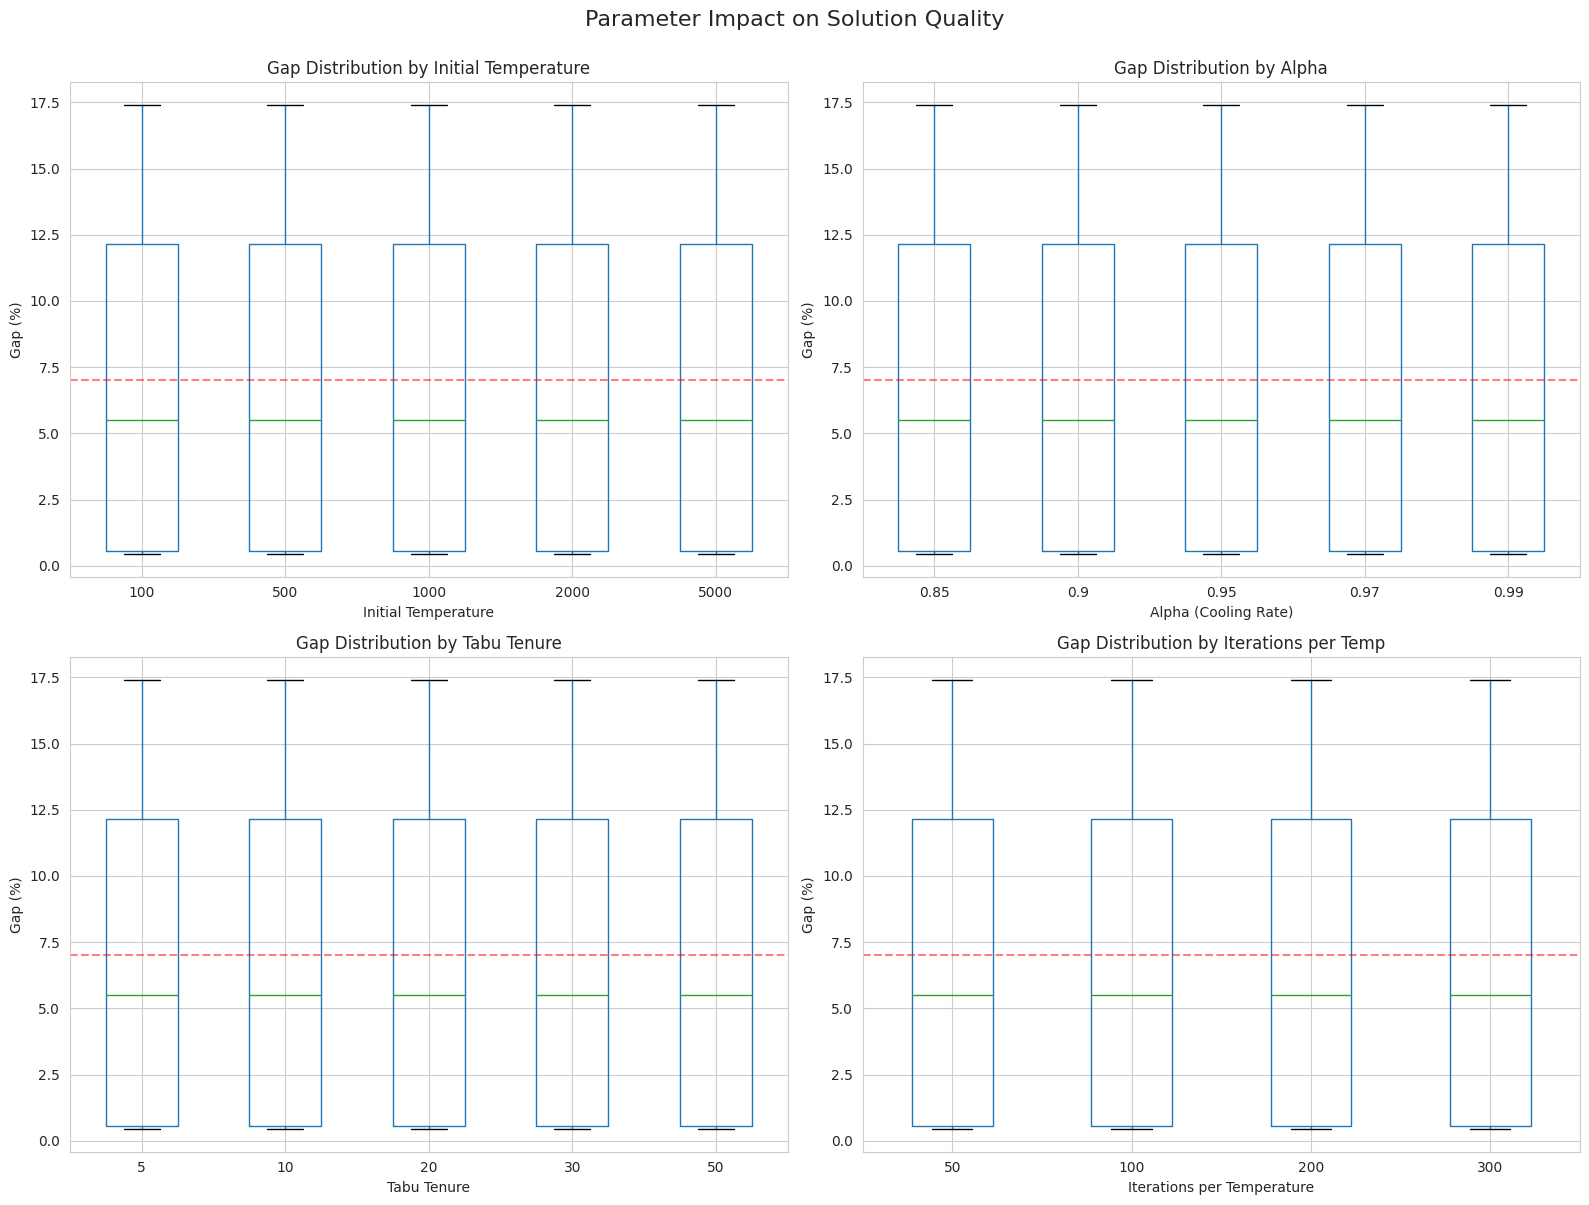

Box plots saved to: analysis_results/plots/boxplots_all_parameters.png


In [23]:
# Create box plots for all parameters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Temperature
if not df_temp[df_temp['gap'].notna()].empty:
    df_temp[df_temp['gap'].notna()].boxplot(column='gap', by='initial_temperature', ax=axes[0, 0])
    axes[0, 0].set_title('Gap Distribution by Initial Temperature')
    axes[0, 0].set_xlabel('Initial Temperature')
    axes[0, 0].set_ylabel('Gap (%)')
    axes[0, 0].axhline(y=7, color='r', linestyle='--', alpha=0.5)

# Alpha
if not df_alpha[df_alpha['gap'].notna()].empty:
    df_alpha[df_alpha['gap'].notna()].boxplot(column='gap', by='alpha', ax=axes[0, 1])
    axes[0, 1].set_title('Gap Distribution by Alpha')
    axes[0, 1].set_xlabel('Alpha (Cooling Rate)')
    axes[0, 1].set_ylabel('Gap (%)')
    axes[0, 1].axhline(y=7, color='r', linestyle='--', alpha=0.5)

# Tabu Tenure
if not df_tenure[df_tenure['gap'].notna()].empty:
    df_tenure[df_tenure['gap'].notna()].boxplot(column='gap', by='tabu_tenure', ax=axes[1, 0])
    axes[1, 0].set_title('Gap Distribution by Tabu Tenure')
    axes[1, 0].set_xlabel('Tabu Tenure')
    axes[1, 0].set_ylabel('Gap (%)')
    axes[1, 0].axhline(y=7, color='r', linestyle='--', alpha=0.5)

# Iterations
if not df_iterations[df_iterations['gap'].notna()].empty:
    df_iterations[df_iterations['gap'].notna()].boxplot(column='gap', by='iterations_per_temp', ax=axes[1, 1])
    axes[1, 1].set_title('Gap Distribution by Iterations per Temp')
    axes[1, 1].set_xlabel('Iterations per Temperature')
    axes[1, 1].set_ylabel('Gap (%)')
    axes[1, 1].axhline(y=7, color='r', linestyle='--', alpha=0.5)

plt.suptitle('Parameter Impact on Solution Quality', fontsize=16, y=1.00)
plt.tight_layout()
plt.savefig('analysis_results/plots/boxplots_all_parameters.png', dpi=300, bbox_inches='tight')
plt.show()

print("Box plots saved to: analysis_results/plots/boxplots_all_parameters.png")

## Recommendations

In [24]:
print("\n" + "="*70)
print("PARAMETER RECOMMENDATIONS")
print("="*70)

# Find best parameter values based on average gap
recommendations = {}

# Best temperature
if not df_temp[df_temp['gap'].notna()].empty:
    best_temp = df_temp[df_temp['gap'].notna()].groupby('initial_temperature')['gap'].mean().idxmin()
    recommendations['initial_temperature'] = best_temp
    print(f"\nRecommended Initial Temperature: {best_temp}")
    print(f"  (Average gap: {df_temp[df_temp['initial_temperature']==best_temp]['gap'].mean():.2f}%)")

# Best alpha
if not df_alpha[df_alpha['gap'].notna()].empty:
    best_alpha = df_alpha[df_alpha['gap'].notna()].groupby('alpha')['gap'].mean().idxmin()
    recommendations['alpha'] = best_alpha
    print(f"\nRecommended Alpha: {best_alpha}")
    print(f"  (Average gap: {df_alpha[df_alpha['alpha']==best_alpha]['gap'].mean():.2f}%)")

# Best tabu tenure
if not df_tenure[df_tenure['gap'].notna()].empty:
    best_tenure = df_tenure[df_tenure['gap'].notna()].groupby('tabu_tenure')['gap'].mean().idxmin()
    recommendations['tabu_tenure'] = best_tenure
    print(f"\nRecommended Tabu Tenure: {best_tenure}")
    print(f"  (Average gap: {df_tenure[df_tenure['tabu_tenure']==best_tenure]['gap'].mean():.2f}%)")

# Best iterations
if not df_iterations[df_iterations['gap'].notna()].empty:
    best_iters = df_iterations[df_iterations['gap'].notna()].groupby('iterations_per_temp')['gap'].mean().idxmin()
    recommendations['iterations_per_temp'] = best_iters
    print(f"\nRecommended Iterations per Temperature: {best_iters}")
    print(f"  (Average gap: {df_iterations[df_iterations['iterations_per_temp']==best_iters]['gap'].mean():.2f}%)")

print("\n" + "="*70)

# Save recommendations
with open('analysis_results/recommended_config.yaml', 'w') as f:
    yaml.dump(recommendations, f)
    
print("\nRecommendations saved to: analysis_results/recommended_config.yaml")


PARAMETER RECOMMENDATIONS

Recommended Initial Temperature: 100
  (Average gap: 7.22%)

Recommended Alpha: 0.85
  (Average gap: 7.22%)

Recommended Tabu Tenure: 5
  (Average gap: 7.22%)

Recommended Iterations per Temperature: 50
  (Average gap: 7.22%)


Recommendations saved to: analysis_results/recommended_config.yaml


In [25]:
print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)
print("\nAll results have been saved to:")
print("  - CSV files: analysis_results/csv/")
print("  - Plots: analysis_results/plots/")
print("  - Recommended config: analysis_results/recommended_config.yaml")
print("\n" + "="*70)


ANALYSIS COMPLETE!

All results have been saved to:
  - CSV files: analysis_results/csv/
  - Plots: analysis_results/plots/
  - Recommended config: analysis_results/recommended_config.yaml

